In [1]:
from collections import defaultdict
import numpy as np
import math


class MeanShift:
    def __init__(self, epsilon=1e-5, band_width=2, min_fre=3, bin_seeding=False):
        self.epsilon = epsilon
        self.band_width = band_width
        self.min_fre = min_fre  # 可以作为起始质心的球体内最少的样本数目
        self.bin_seeding = bin_seeding
        self.radius2 = self.band_width ** 2  # 高维球体半径的平方

        self.N = None
        self.labels = None
        self.centers = []
        self.center_score = []

    def init_param(self, data):
        # 初始化参数
        self.N = data.shape[0]
        self.labels = -1 * np.ones(self.N)
        return

    def get_seeds(self, data):
        # 获取可以作为起始质心的点（seed）
        if self.bin_seeding:
            binsize = self.band_width
        else:
            binsize = 1
        seed_list = []
        seeds_fre = defaultdict(int)
        for sample in data:
            seed = tuple(np.round(sample / binsize))  # 将数据粗粒化，以防止非常近的样本点都作为起始质心
            seeds_fre[seed] += 1
        for seed, fre in seeds_fre.items():
            if fre >= self.min_fre:
                seed_list.append(np.array(seed))
        if not seed_list:
            raise ValueError('the bin size and min_fre are not proper')
        return seed_list

    def euclidean_dis2(self, center, sample):
        # 计算均值点到每个样本点的欧式距离（平方）
        delta = center - sample
        return delta @ delta

    def gaussian_kel(self, dis2):
        # 计算高斯核
        return 1.0 / self.band_width * (2 * math.pi) ** (-1.0 / 2) * math.exp(-dis2 / (2 * self.band_width ** 2))

    def shift_center(self, current_center, data, tmp_center_score):
        # 计算下一个漂移的坐标
        denominator = 0  # 分母
        numerator = np.zeros_like(current_center)  # 分子, 一维数组形式
        for ind, sample in enumerate(data):
            dis2 = self.euclidean_dis2(current_center, sample)
            if dis2 <= self.radius2:
                tmp_center_score += 1
            d = self.gaussian_kel(dis2)
            denominator += d
            numerator += d * sample
        return numerator / denominator

    def classify(self, data):
        # 根据最近邻将数据分类到最近的簇中
        center_arr = np.array(self.centers)
        for i in range(self.N):
            delta = center_arr - data[i]
            dis2 = np.sum(delta * delta, axis=1)
            self.labels[i] = np.argmin(dis2)
        return

    def fit(self, data):
        # 训练主函数
        self.init_param(data)
        seed_list = self.get_seeds(data)
        for seed in seed_list:
            current_center = seed
            tmp_center_score = 0
            # 进行一次独立的均值漂移
            while True:
                next_center = self.shift_center(current_center, data, tmp_center_score)
                delta_dis = np.linalg.norm(next_center - current_center, 2)
                if delta_dis < self.epsilon:
                    break
                current_center = next_center
            # 若该次漂移结束后，最终的质心与已存在的质心距离小于带宽，则合并
            for i in range(len(self.centers)):
                if np.linalg.norm(current_center - self.centers[i], 2) < self.band_width:
                    if tmp_center_score > self.center_score[i]:
                        self.centers[i] = current_center
                        self.center_score[i] = tmp_center_score
                    break
            else:
                self.centers.append(current_center)
                self.center_score.append(tmp_center_score)
        self.classify(data)
        return

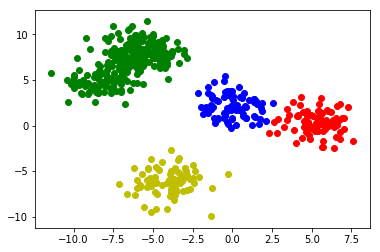

In [8]:
from sklearn.datasets import make_blobs

data, label = make_blobs(n_samples=500, centers=6, cluster_std=1.2, random_state=5)
MS = MeanShift(band_width=1.5)
MS.fit(data)
labels = MS.labels
import matplotlib.pyplot as plt
from itertools import cycle


def visualize(data, labels):
    color = 'bgrym'
    unique_label = np.unique(labels)
    for col, label in zip(cycle(color), unique_label):
        partial_data = data[np.where(labels == label)]
        plt.scatter(partial_data[:, 0], partial_data[:, 1], color=col)
    plt.show()
    return 
visualize(data, labels)

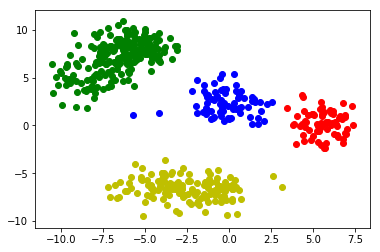

In [7]:
visualize(data, labels)

In [4]:
MS.labels

array([0., 3., 0., 1., 1., 1., 1., 1., 2., 1., 0., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 3., 3., 0., 0., 1., 0., 2., 2., 1., 1., 3., 2.,
       3., 1., 2., 1., 1., 2., 3., 1., 0., 2., 1., 0., 2., 3., 1., 2., 2.,
       3., 3., 3., 2., 2., 1., 1., 1., 3., 0., 3., 3., 3., 2., 1., 0., 2.,
       0., 2., 2., 1., 1., 3., 1., 1., 1., 3., 3., 3., 1., 0., 2., 1., 1.,
       2., 3., 3., 3., 1., 2., 2., 0., 2., 2., 1., 1., 0., 1., 1., 2., 3.,
       1., 1., 0., 1., 1., 1., 1., 1., 2., 2., 3., 1., 1., 2., 1., 3., 1.,
       2., 1., 1., 3., 3., 3., 1., 2., 3., 0., 3., 1., 1., 0., 1., 3., 1.,
       3., 1., 1., 0., 2., 0., 3., 1., 1., 1., 3., 0., 1., 3., 0., 3., 2.,
       3., 0., 0., 3., 0., 3., 2., 0., 2., 1., 1., 1., 1., 0., 1., 2., 1.,
       0., 3., 3., 1., 3., 2., 2., 0., 1., 0., 1., 1., 3., 2., 0., 1., 0.,
       2., 1., 1., 0., 1., 3., 1., 1., 2., 3., 2., 3., 3., 0., 0., 1., 0.,
       1., 1., 3., 2., 2., 0., 1., 1., 2., 1., 3., 2., 0., 2., 3., 0., 2.,
       1., 1., 1., 2., 1.